# Notebook for the Increasing Returns Paper

This Jupyter Notebook contains the analyses for the paper "Increasing, not Diminishing: Investigating the Returns of Highly Maintainable Code" submitted for peer-review.

## Prerequisites

This notebook uses various external libraries.

In [1]:
# Import libraries and configure this notebook
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
# Util functions in a seperate file
import Functions as ily

Read the CSV file and parse it into a Pandas data frame.

The parsed data frame contains rows of changes to unique files. Each row contains the following variables:

* `code_health`: Average Code Health score for changes to the file.
* `lead-time-minutes`: Average Time-in-Development in minutes for changes to the file. 
* `total_defects`: Total number of changes to the file connected to Jira issues of type "bug".
* `language`: Programming language of the file.

In [2]:
increasing_returns_df = pd.read_csv('./data/increasing_returns.csv', sep=',', decimal=".")
increasing_returns_df.describe()

,code_health,lead_time_minutes,total_defects
count,46211.000000,4.621100e+04,46211.000000
mean,9.604727,7.501023e+03,0.496830
std,1.070784,1.980885e+04,2.089526
min,1.000000,6.000000e+01,0.000000
25%,9.750000,1.380000e+03,0.000000
50%,10.000000,3.360000e+03,0.000000
75%,10.000000,7.680000e+03,0.000000
max,10.000000,1.452780e+06,110.000000


Initializing variables and reshaping data for subsequent analysis.

In [3]:
x_bugs = increasing_returns_df['code_health'].to_numpy()
x_bugs_reshaped = x_bugs.reshape(-1, 1)
y_bugs = increasing_returns_df['total_defects'].to_numpy()
x_time = increasing_returns_df[increasing_returns_df['lead_time_minutes'].notna()]['code_health'].to_numpy()
y_time = increasing_returns_df[increasing_returns_df['lead_time_minutes'].notna()]['lead_time_minutes'].to_numpy()
x_time_reshaped = x_time.reshape(-1, 1)

## Exploring the data

We find that the data is heavily skewed.

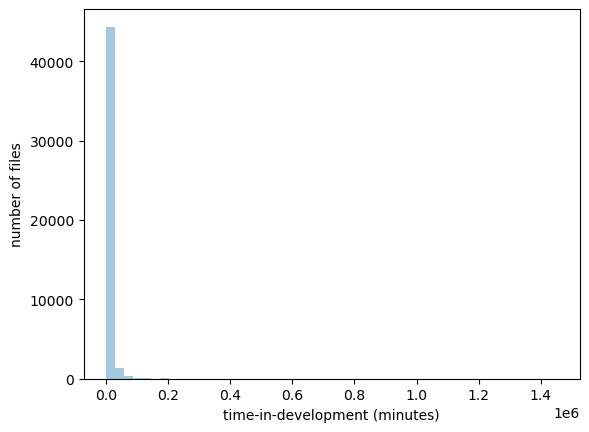

In [4]:
plot = sns.distplot(increasing_returns_df['lead_time_minutes'], kde=False)
plt.xlabel("time-in-development (minutes)")
plt.ylabel("number of files")
plt.show(plot)

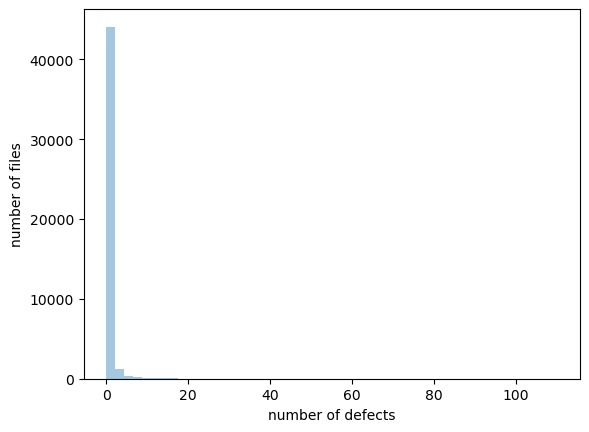

In [5]:
plot = sns.distplot(increasing_returns_df['total_defects'], kde=False)
plt.xlabel("number of defects")
plt.ylabel("number of files")
plt.show(plot)

In [6]:
increasing_returns_df['language'].value_counts()

C#                   7207
C++                  6342
TypeScript           4696
Java                 4512
Python               4001
JavaScript           3700
Clojure              2448
Swift                1430
C                    1137
Go                   1112
PHP                   585
Ruby                  514
Elixir                413
Kotlin                324
Scala                 112
Groovy                110
Objective-C           104
Vue                    93
ClojureScript          60
Rust                   49
Objective C++          46
PowerShell             25
Perl                    1
ECMAScript Module       1
Objective C             1
Name: language, dtype: int64

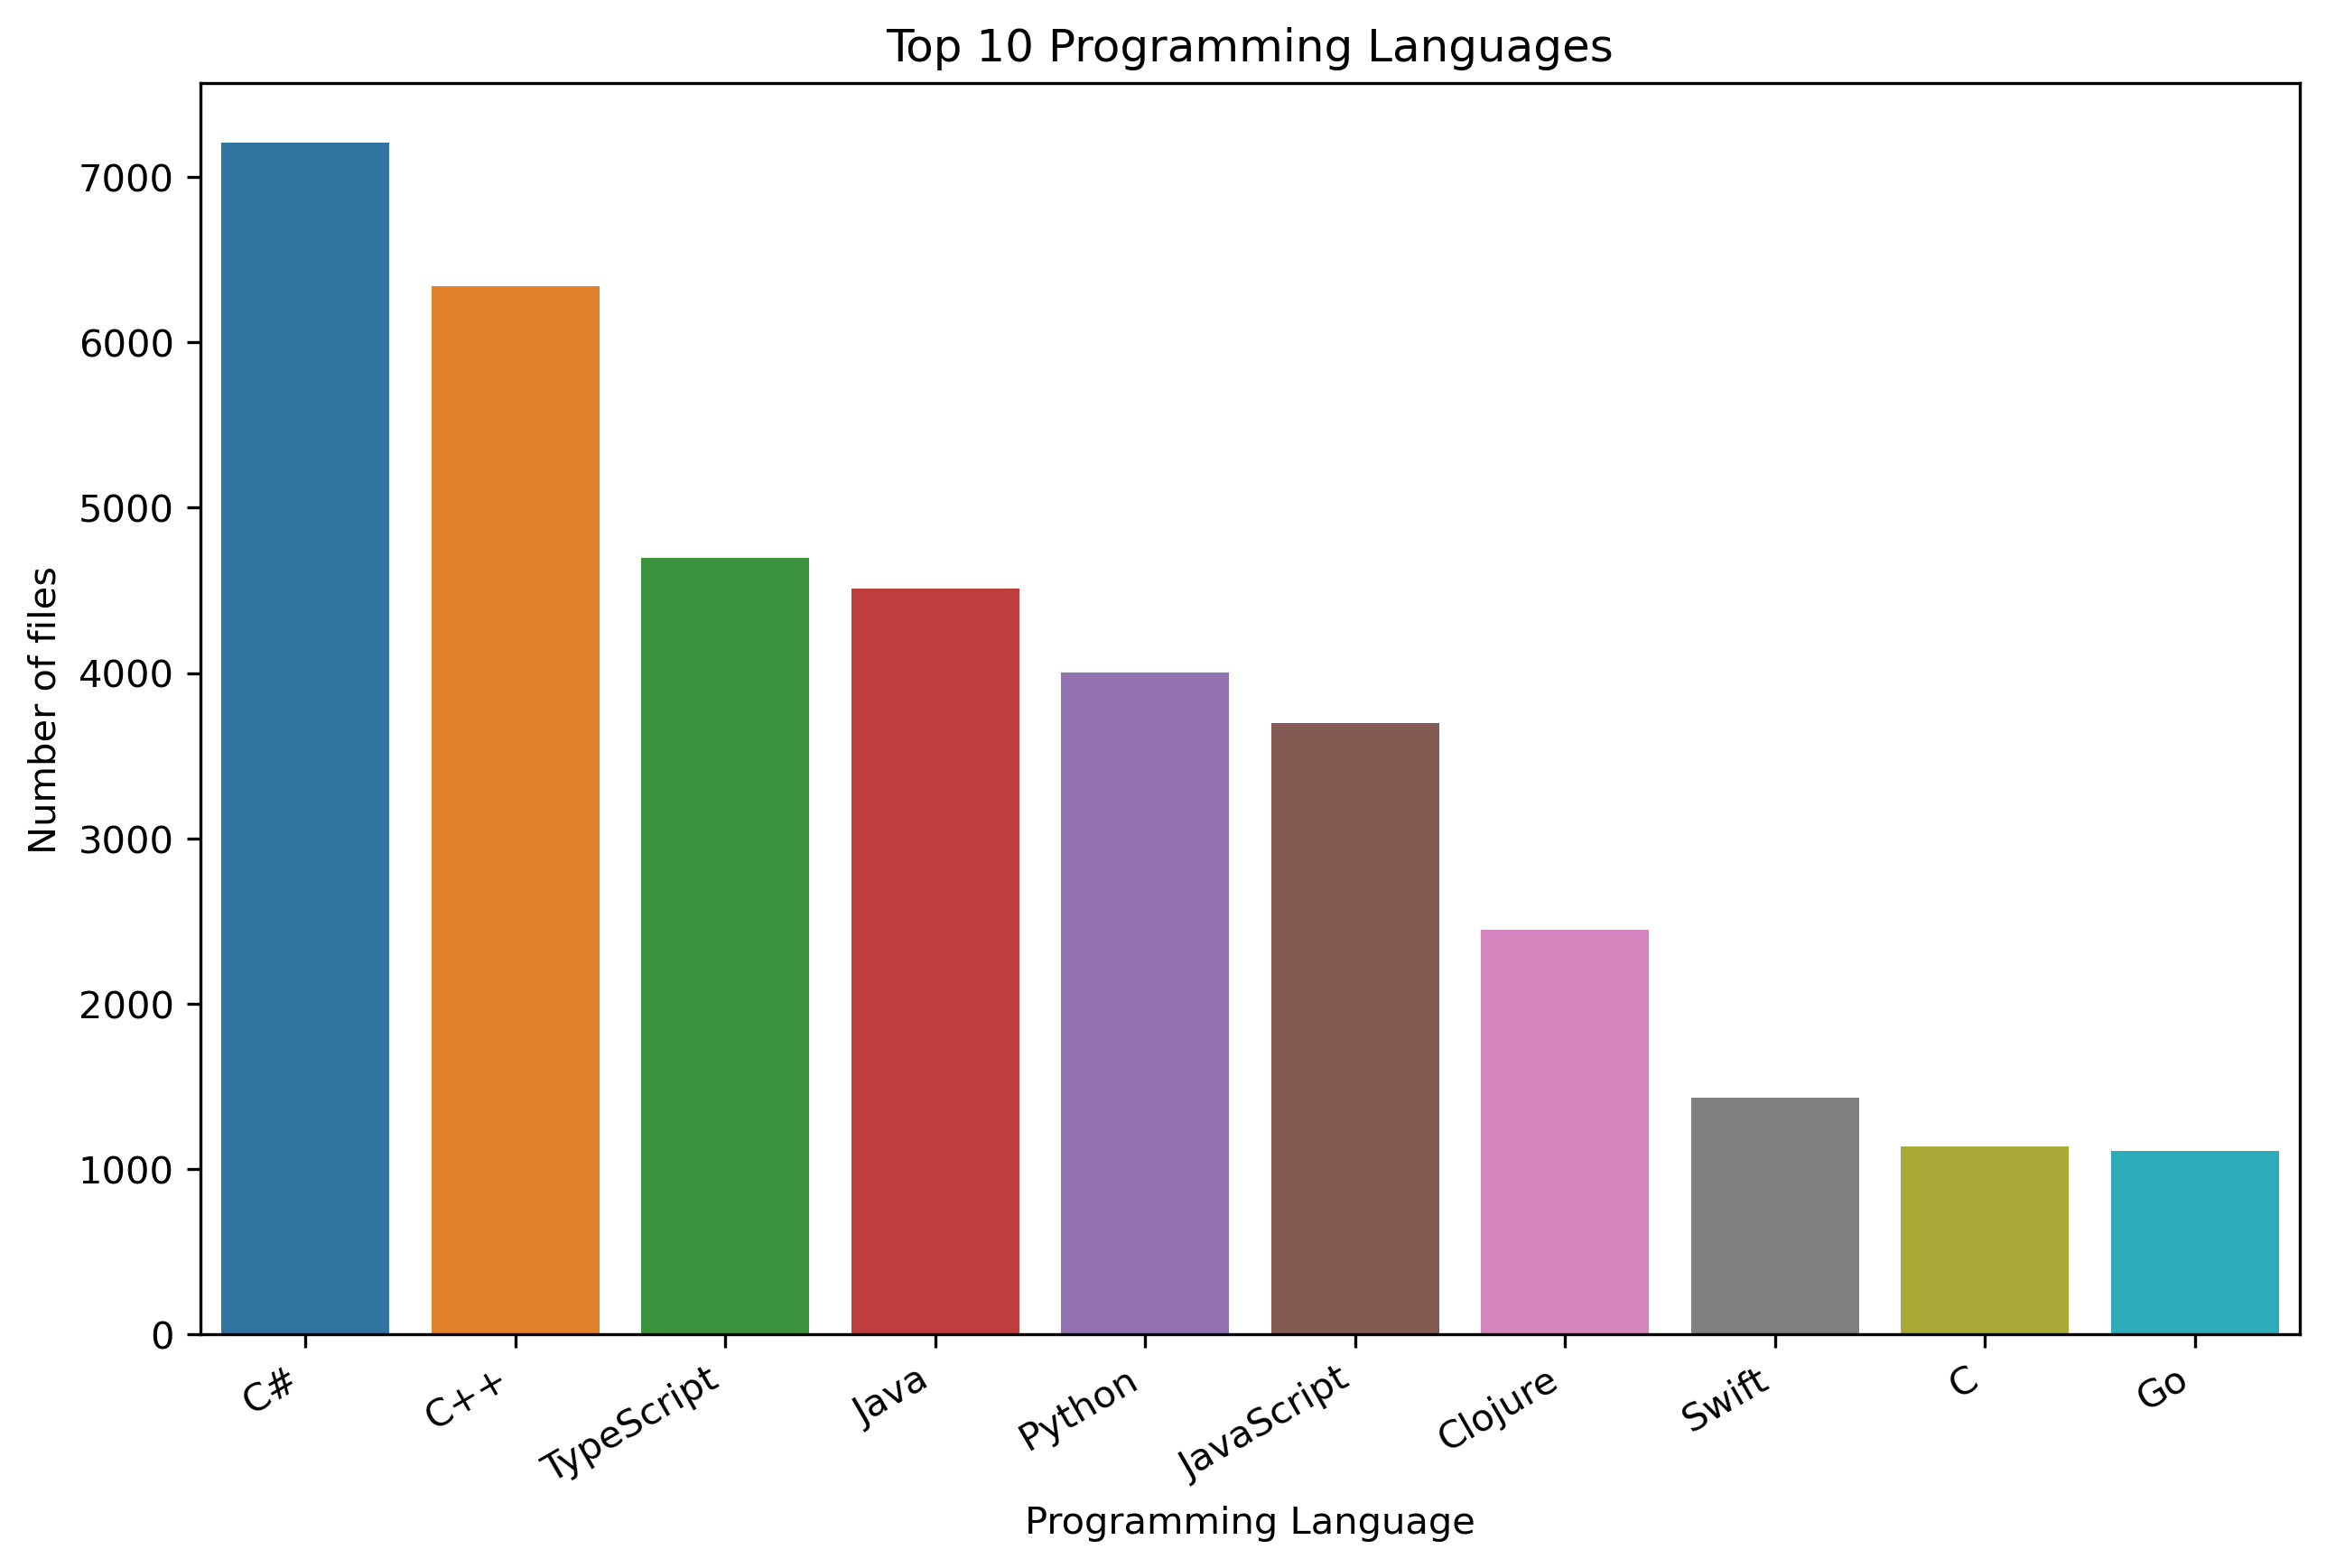

In [7]:
top_10_languages = increasing_returns_df['language'].value_counts().head(10).index
plt.figure(figsize=(10, 6), dpi=300)
ax_lang = sns.countplot(data=increasing_returns_df, x='language', order=top_10_languages)
ax_lang.set(xlabel='Programming Language', ylabel='Number of files', title='Top 10 Programming Languages')
plt.xticks(rotation=30, horizontalalignment='right') # Rotate x-axis labels for better readability
plt.show()

There are 25 programming languages are represented in the dataset. The two most common languages are C# and C++. There is also a substantial part of JavaScript and TypeScript. Java and Python are also well-represented in the dataset. The dataset is diverse and we conclude that it represents contemporary software development.

## Third-degree polynomial models

The accompanying Notebook regression_modeling.ipynb shows our evaluation of alternative regression models. We chose to proceed with third-degree polynomial models.

In [8]:
# Fitting the regression models
polynomial_coefficients_bugs, covariance_matrix_bugs = np.polyfit(x_bugs, y_bugs, 3, cov="true")
PolReg_bugs_a, PolReg_bugs_b, PolReg_bugs_c, PolReg_bugs_d = polynomial_coefficients_bugs

polynomial_coefficients_time, covariance_matrix_time = np.polyfit(x_time, y_time, 3, cov="true")
PolReg_time_a, PolReg_time_b, PolReg_time_c, PolReg_time_d = polynomial_coefficients_time

We use bootstrapping to investigate the uncertainty of the model.

In [9]:
#make a "sample_size" sized bootstrap sample from df
def bootstrap_sample(sample_size, df):
    return df.iloc[np.random.randint(df.shape[0], size=sample_size)]

In [67]:
def run_plot_bootstrap(nbr_of_samples, df):
    
    # We set the size of the bootstrapping sample to the same as dataframe.
    # We make each bootstrap sample the same size as the original dataset.
    # This can be decreased to save computational resources.
    sample_size = df.shape[0]
    
    x_new = np.arange(1, 11)
    
    # Plot for Defects
    plt.figure(figsize=(7, 6), dpi=300)
    for i in tqdm(range(nbr_of_samples), desc='Defects'):
        sample = bootstrap_sample(sample_size, df)
        coeff_bug = ily.bug_Poly_Regression(sample)
        y_pred_bug = np.polyval(coeff_bug, x_new)
        plt.plot(x_new, y_pred_bug, color='lightsteelblue', alpha=0.3)
    
    p_bug = ily.bug_Poly_Regression(df)
    y_pred_bug = np.polyval(p_bug, x_new)
    
    plt.plot(x_new, y_pred_bug, color='r')
    plt.xlabel('Code Health')
    plt.ylabel('Avg. #defects')
    plt.show()
    
    # Plot for Time-in-Development
    plt.figure(figsize=(7, 6), dpi=300)
    for i in tqdm(range(nbr_of_samples), desc='Time'):
        sample = bootstrap_sample(sample_size, df)
        coeff_time = ily.time_Poly_Regression(sample)
        y_pred_time = np.polyval(coeff_time, x_new)
        plt.plot(x_new, y_pred_time, color='lightsteelblue', alpha=0.3)
    
    p_time = ily.time_Poly_Regression(df)
    y_pred_time = np.polyval(p_time, x_new)
    
    plt.plot(x_new, y_pred_time, color='r')
    plt.xlabel('Code Health')
    plt.ylabel('Avg. Time-in-Development')
    plt.show()
    
    return p_bug, p_time


Defects: 100%|█████████████████████████████████| 10000/10000 [00:47<00:00, 212.33it/s]


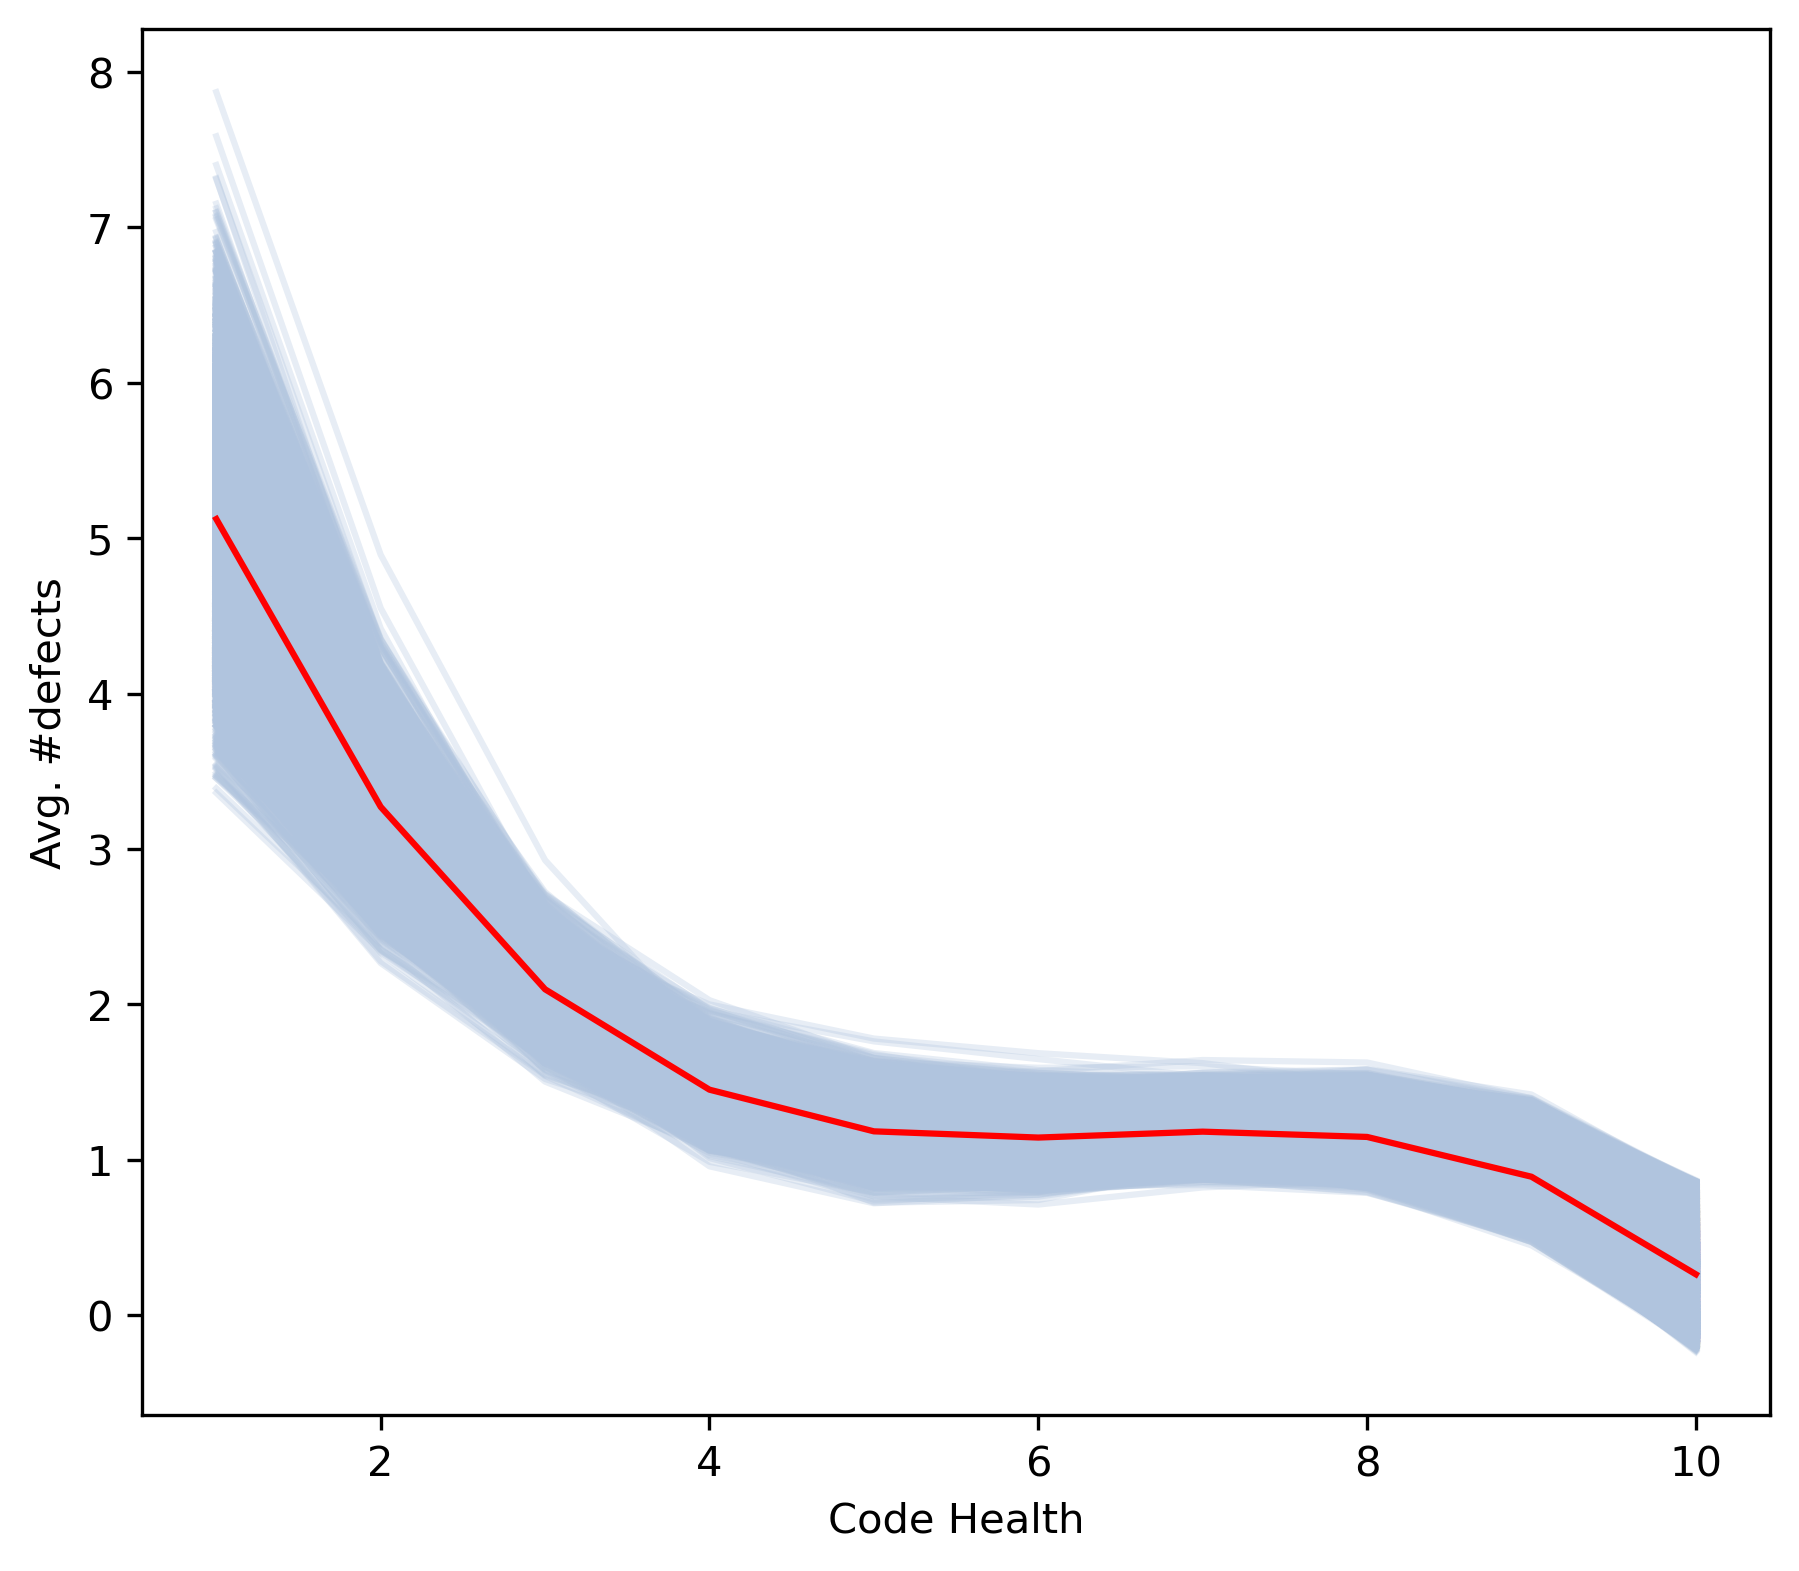

Time: 100%|████████████████████████████████████| 10000/10000 [01:05<00:00, 151.97it/s]


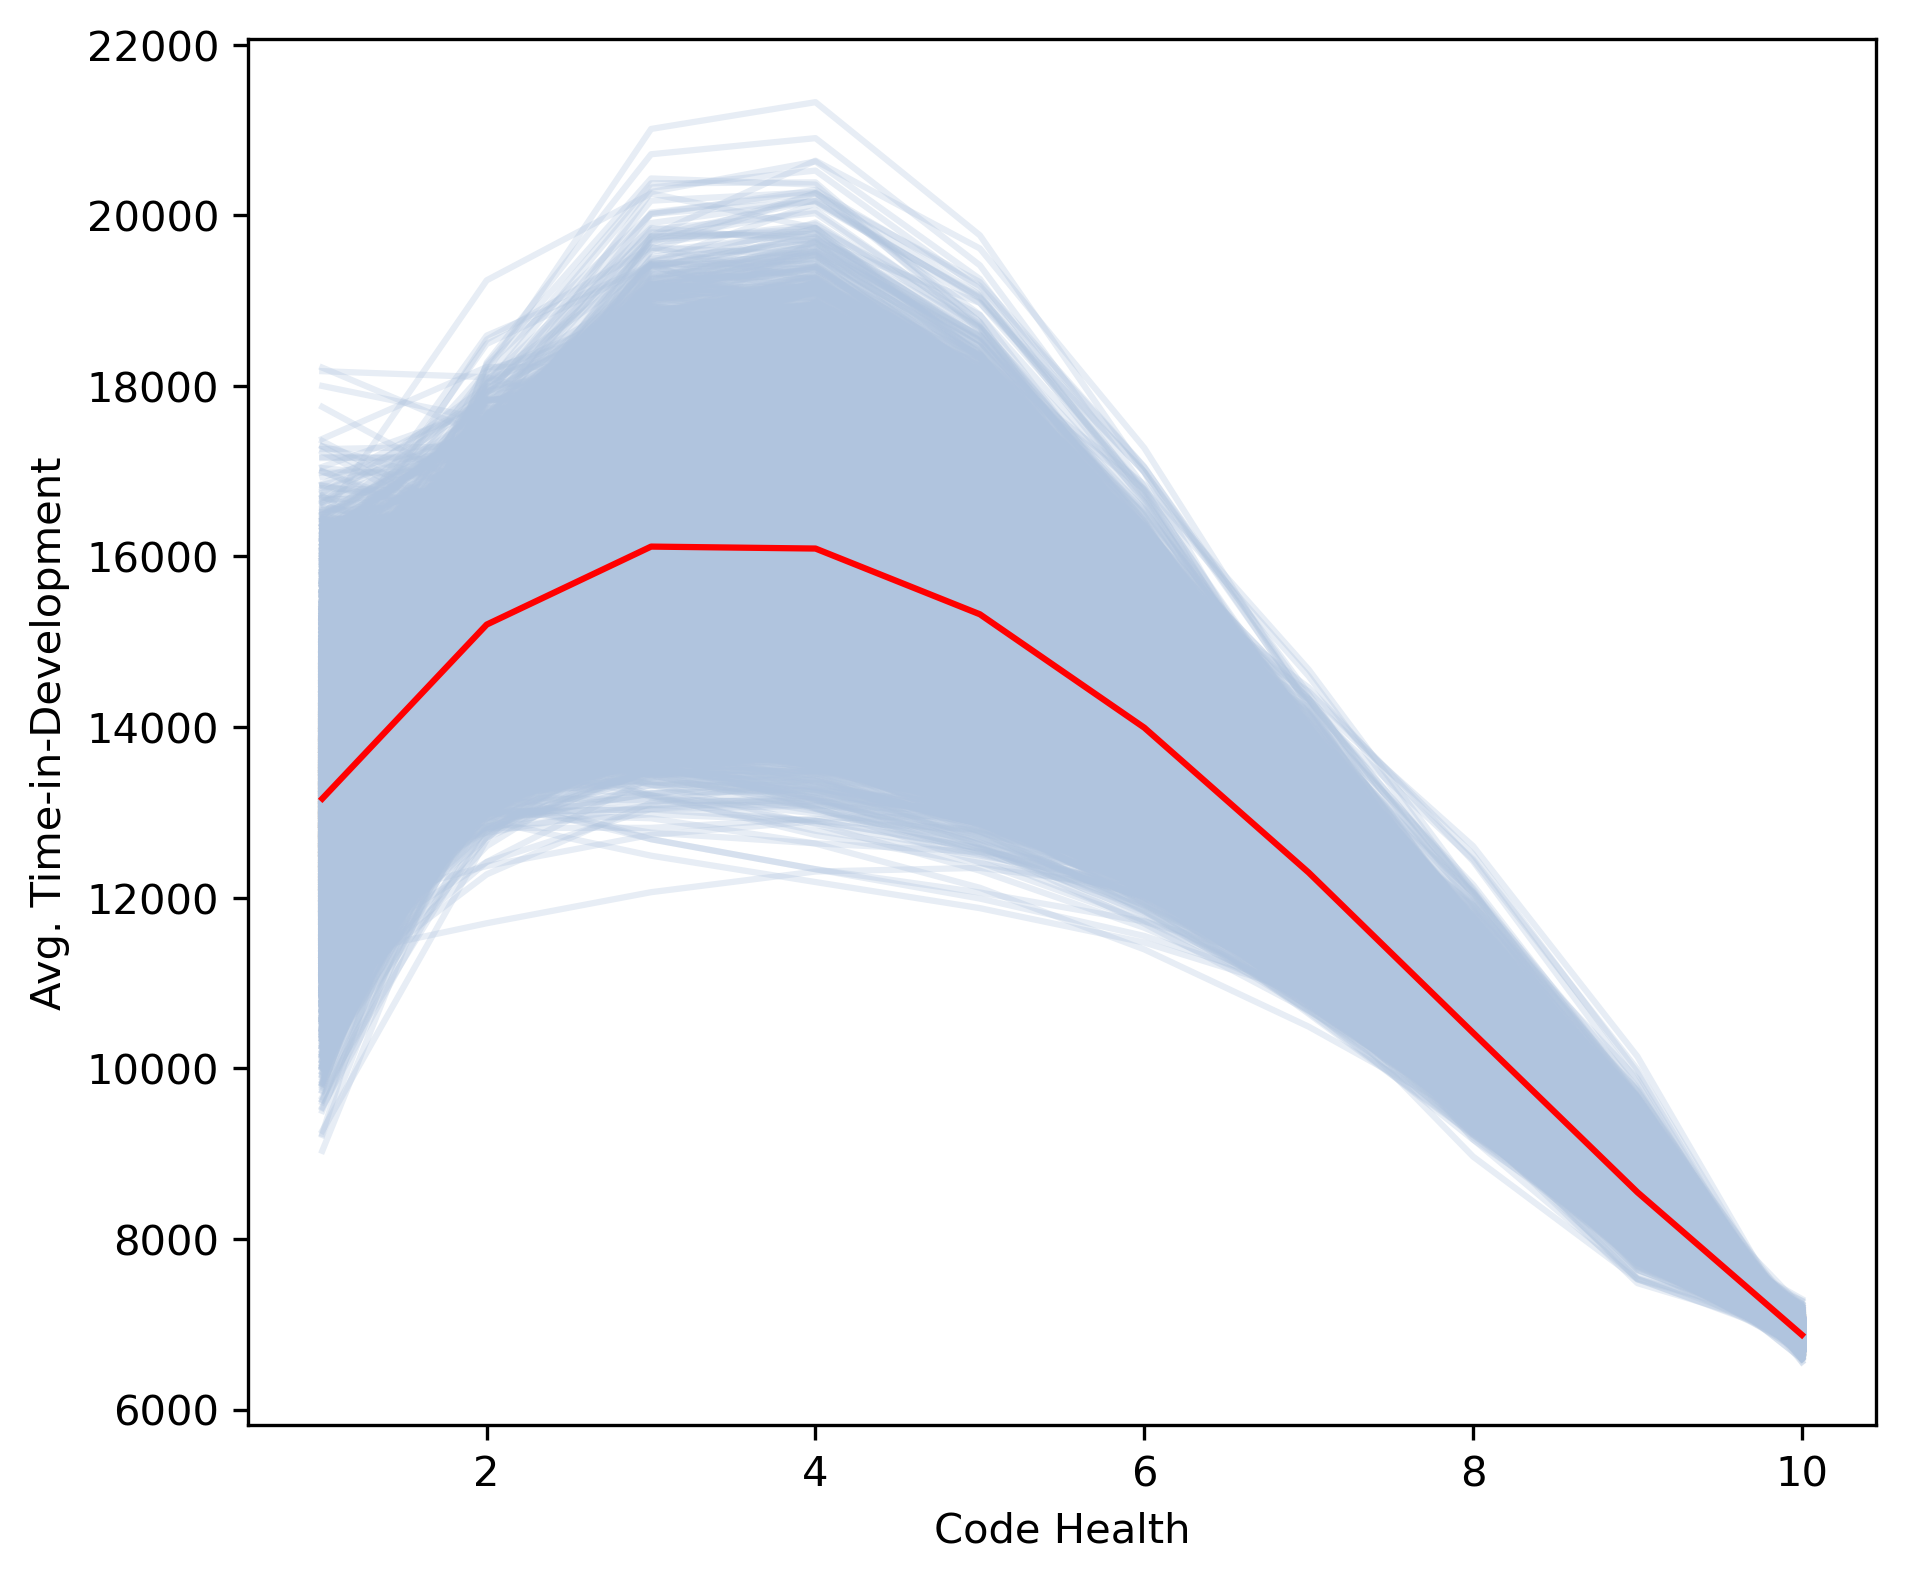

In [68]:
nbr_bootstrapping_runs=10000
p_bug, p_time = run_plot_bootstrap(nbr_bootstrapping_runs, increasing_returns_df)

## Value Function

We propose a simple value-creation model to discuss the relationship between Code Health (CH) and the value created by a software organization.

The value $v$ is defined as:

$v = c \times (1 - u)$

where:
- $ v $ is the value created by a software organization
- $ c $ is the capacity, representing an organization’s capability to produce valuable output
- $ u $ is the fraction of unplanned work.

Furthermore, we posit two proportionalities in the context of our value-creation model:
1. $ c $ is inversely proportional to the time-in-development.
2. $u$ is proportional to the number of defects.

Finally, we use the value-creation model and the proportionalities to illustrate what different levels of Code Health represent in terms of relative changes. Output from the regression models is used as input to the value-creation model. The analysis relies on a given starting point representing an initial Code Health and a fraction of unplanned work.


### Sampling from the covariance matrices

The value function relies on values sampled from the covariance matrices from the regression models.

In [37]:
# Sampling from the covariance matrices for the value function
sample_size=10000


Sample_bugs_pol=np.zeros((sample_size, len(p_bug)))
for i in range (sample_size):
    p_bis = np.random.multivariate_normal(polynomial_coefficients_bugs, covariance_matrix_bugs)
    Sample_bugs_pol[i]= p_bis

Sample_time_pol=np.zeros((sample_size, len(p_time)))
for i in range (sample_size):
    p_bis = np.random.multivariate_normal(polynomial_coefficients_time, covariance_matrix_time)
    Sample_time_pol[i]= p_bis

### Estimating changes in value creation

The value function implements the calculation of relative changes as presented above. 

In [51]:
def added_value_polynomial(value_creation_old,CH_old,CH_new,unplanned_work_old):
    
    # New capacity ################################
    capacity_old=value_creation_old/(1-unplanned_work_old)
    
    time_old=PolReg_time_a*(CH_old**3)+PolReg_time_b*(CH_old**2)+PolReg_time_c*CH_old+PolReg_time_d
    time_new=PolReg_time_a*(CH_new**3)+PolReg_time_b*(CH_new**2)+PolReg_time_c*CH_new+PolReg_time_d
    
    T_old = Sample_time_pol[:,0]*(CH_old**3)+Sample_time_pol[:,1]*(CH_old**2)+Sample_time_pol[:,2]*CH_old+Sample_time_pol[:,3]
    T_new = Sample_time_pol[:,0]*(CH_new**3)+Sample_time_pol[:,1]*(CH_new**2)+Sample_time_pol[:,2]*CH_new+Sample_time_pol[:,3]
    
    capacity_new=capacity_old*(time_old / time_new)
    Cap_new=capacity_old*(T_old / T_new)
    
    # Bug Reduction ################################
    bugs_old=PolReg_bugs_a*(CH_old**3)+PolReg_bugs_b*(CH_old**2)+PolReg_bugs_c*CH_old+PolReg_bugs_d
    bugs_new=PolReg_bugs_a*(CH_new**3)+PolReg_bugs_b*(CH_new**2)+PolReg_bugs_c*CH_new+PolReg_bugs_d
    
    B_old = Sample_bugs_pol[:,0]*(CH_old**3)+Sample_bugs_pol[:,1]*(CH_old**2)+Sample_bugs_pol[:,2]*CH_old+Sample_bugs_pol[:,3]
    B_new = Sample_bugs_pol[:,0]*(CH_new**3)+Sample_bugs_pol[:,1]*(CH_new**2)+Sample_bugs_pol[:,2]*CH_new+Sample_bugs_pol[:,3]
    
    # New Unplanned Work ################################
    unplanned_work_new=unplanned_work_old*(bugs_new / bugs_old)
    UN_W_new=unplanned_work_old*(B_new / B_old)
    
    # New Value Creation ################################
    value_creation_new=capacity_new*(1-unplanned_work_new)
    VAL_CREAT_new=Cap_new*(1-UN_W_new)
    
    # Added Value ################################
    added_value=value_creation_new-value_creation_old
    ADD_VAL=VAL_CREAT_new-value_creation_old*np.ones_like(VAL_CREAT_new)
    
    return added_value,ADD_VAL

def plot_value(value_creation_old,CH_old,unplanned_work_old):

    X=np.arange(1,10.5,0.5)
    Y=np.zeros_like(X)
    Y_samp=np.zeros((sample_size,Y.shape[0]))
    plt.figure(figsize=(8, 6), dpi=300)
    for i in range(X.shape[0]):
        Y[i],Y_samp[:,i]= added_value_polynomial(value_creation_old,CH_old,X[i],unplanned_work_old)
    
    # Plot the samples to visualize the uncertainty
    for i in range(sample_size):
        plt.plot(X,Y_samp[i],color='lightsteelblue', alpha=0.3)
        
    plt.plot(X,Y)
    plt.plot(CH_old,0,color='#00B38A', marker='o', markersize=12, label='current CH')
    plt.xlabel('Code Health', fontsize=16)
    plt.ylabel('Relative difference (%)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(-100, 200)
    plt.legend(fontsize=14)
    plt.show()

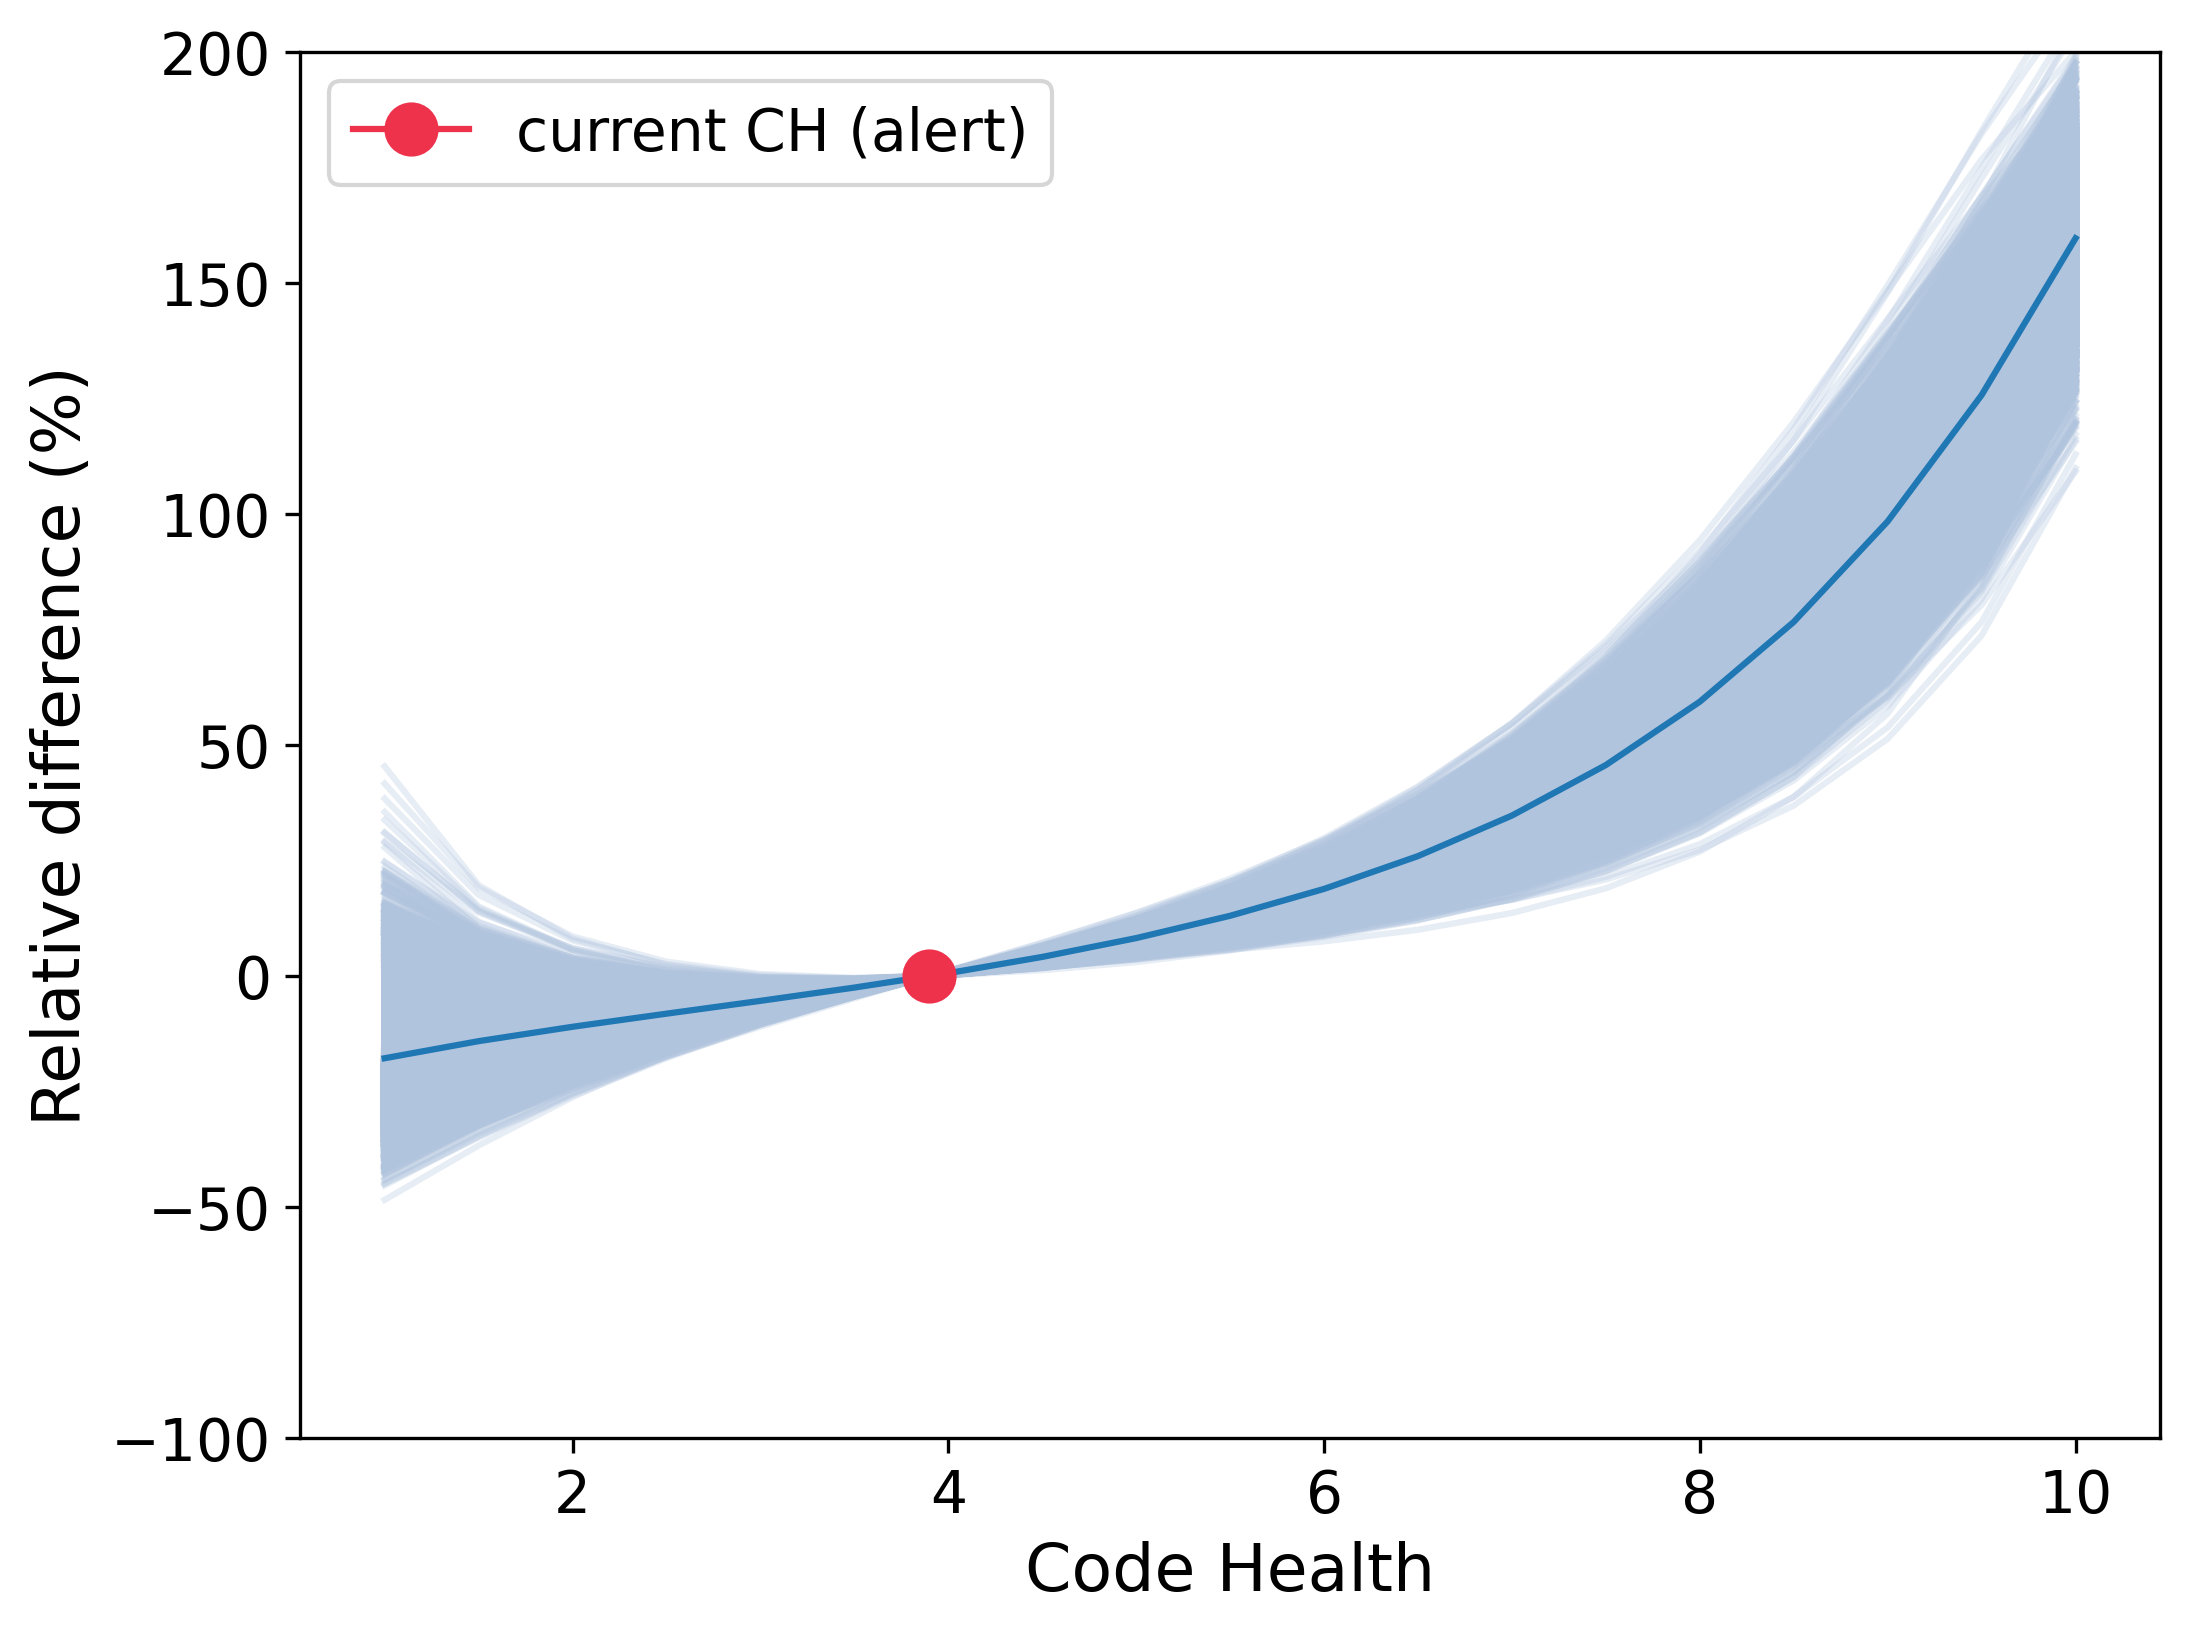

In [49]:
plot_value(100,3.9,0.12)

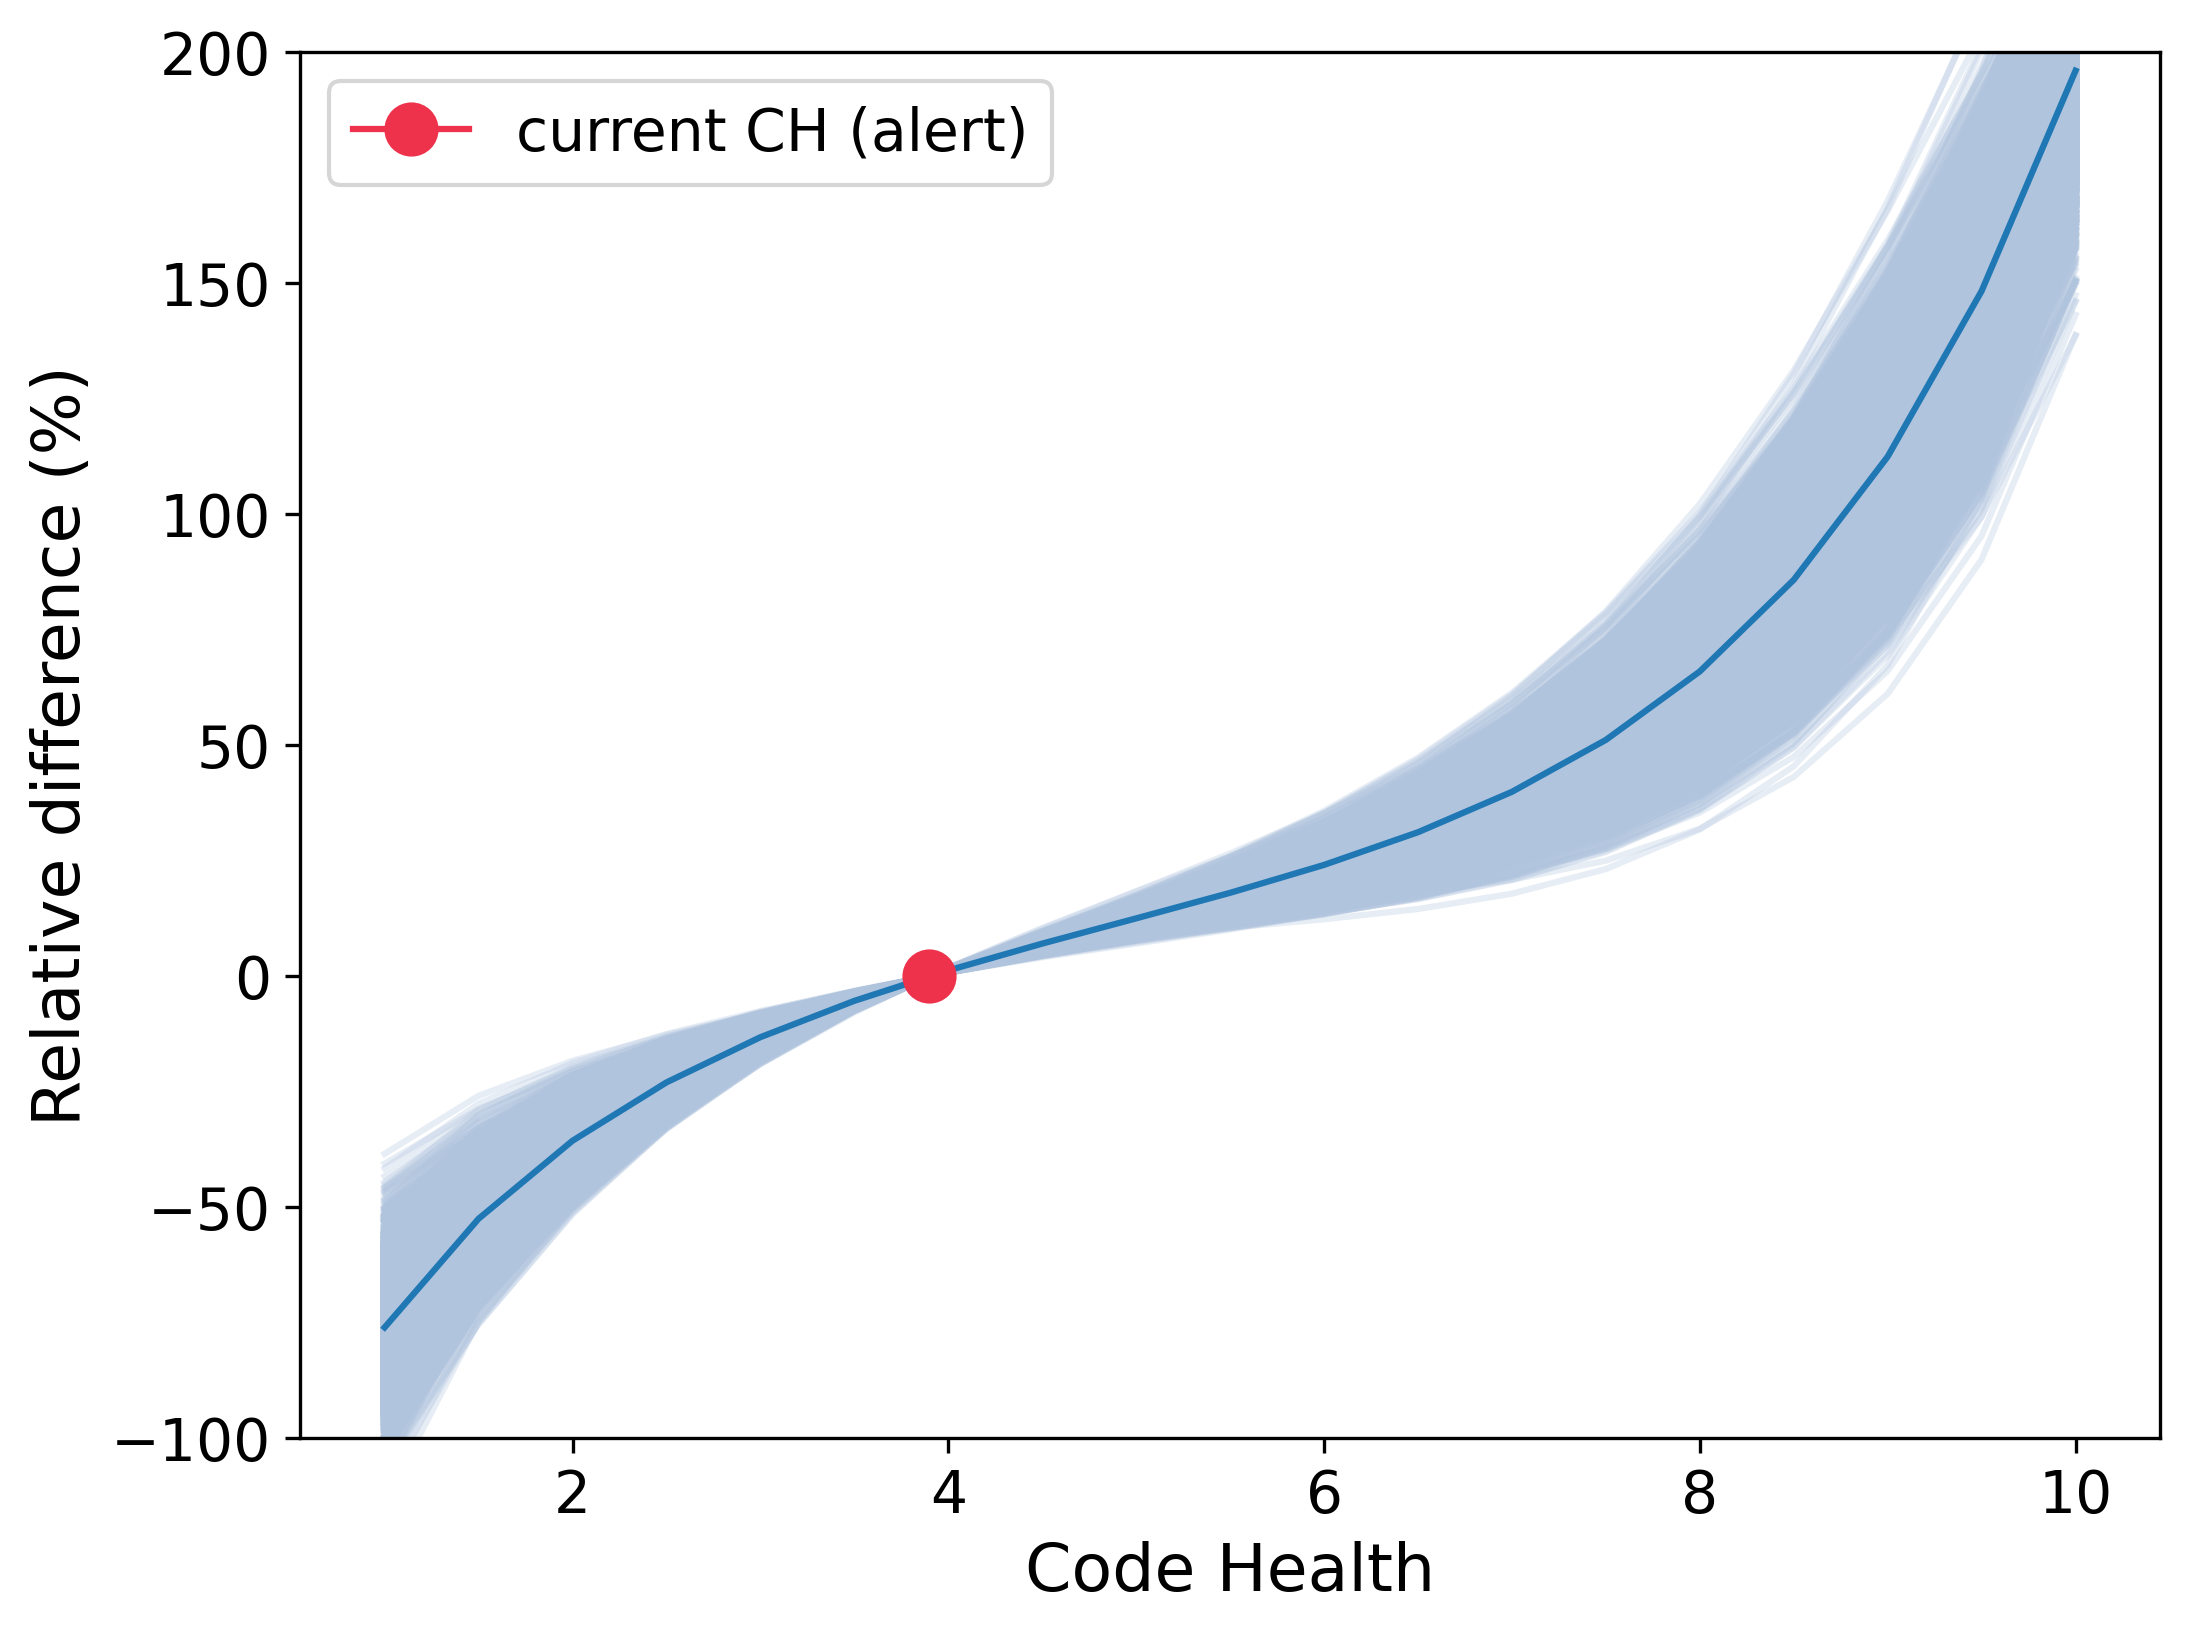

In [50]:
plot_value(100,3.9,0.25)

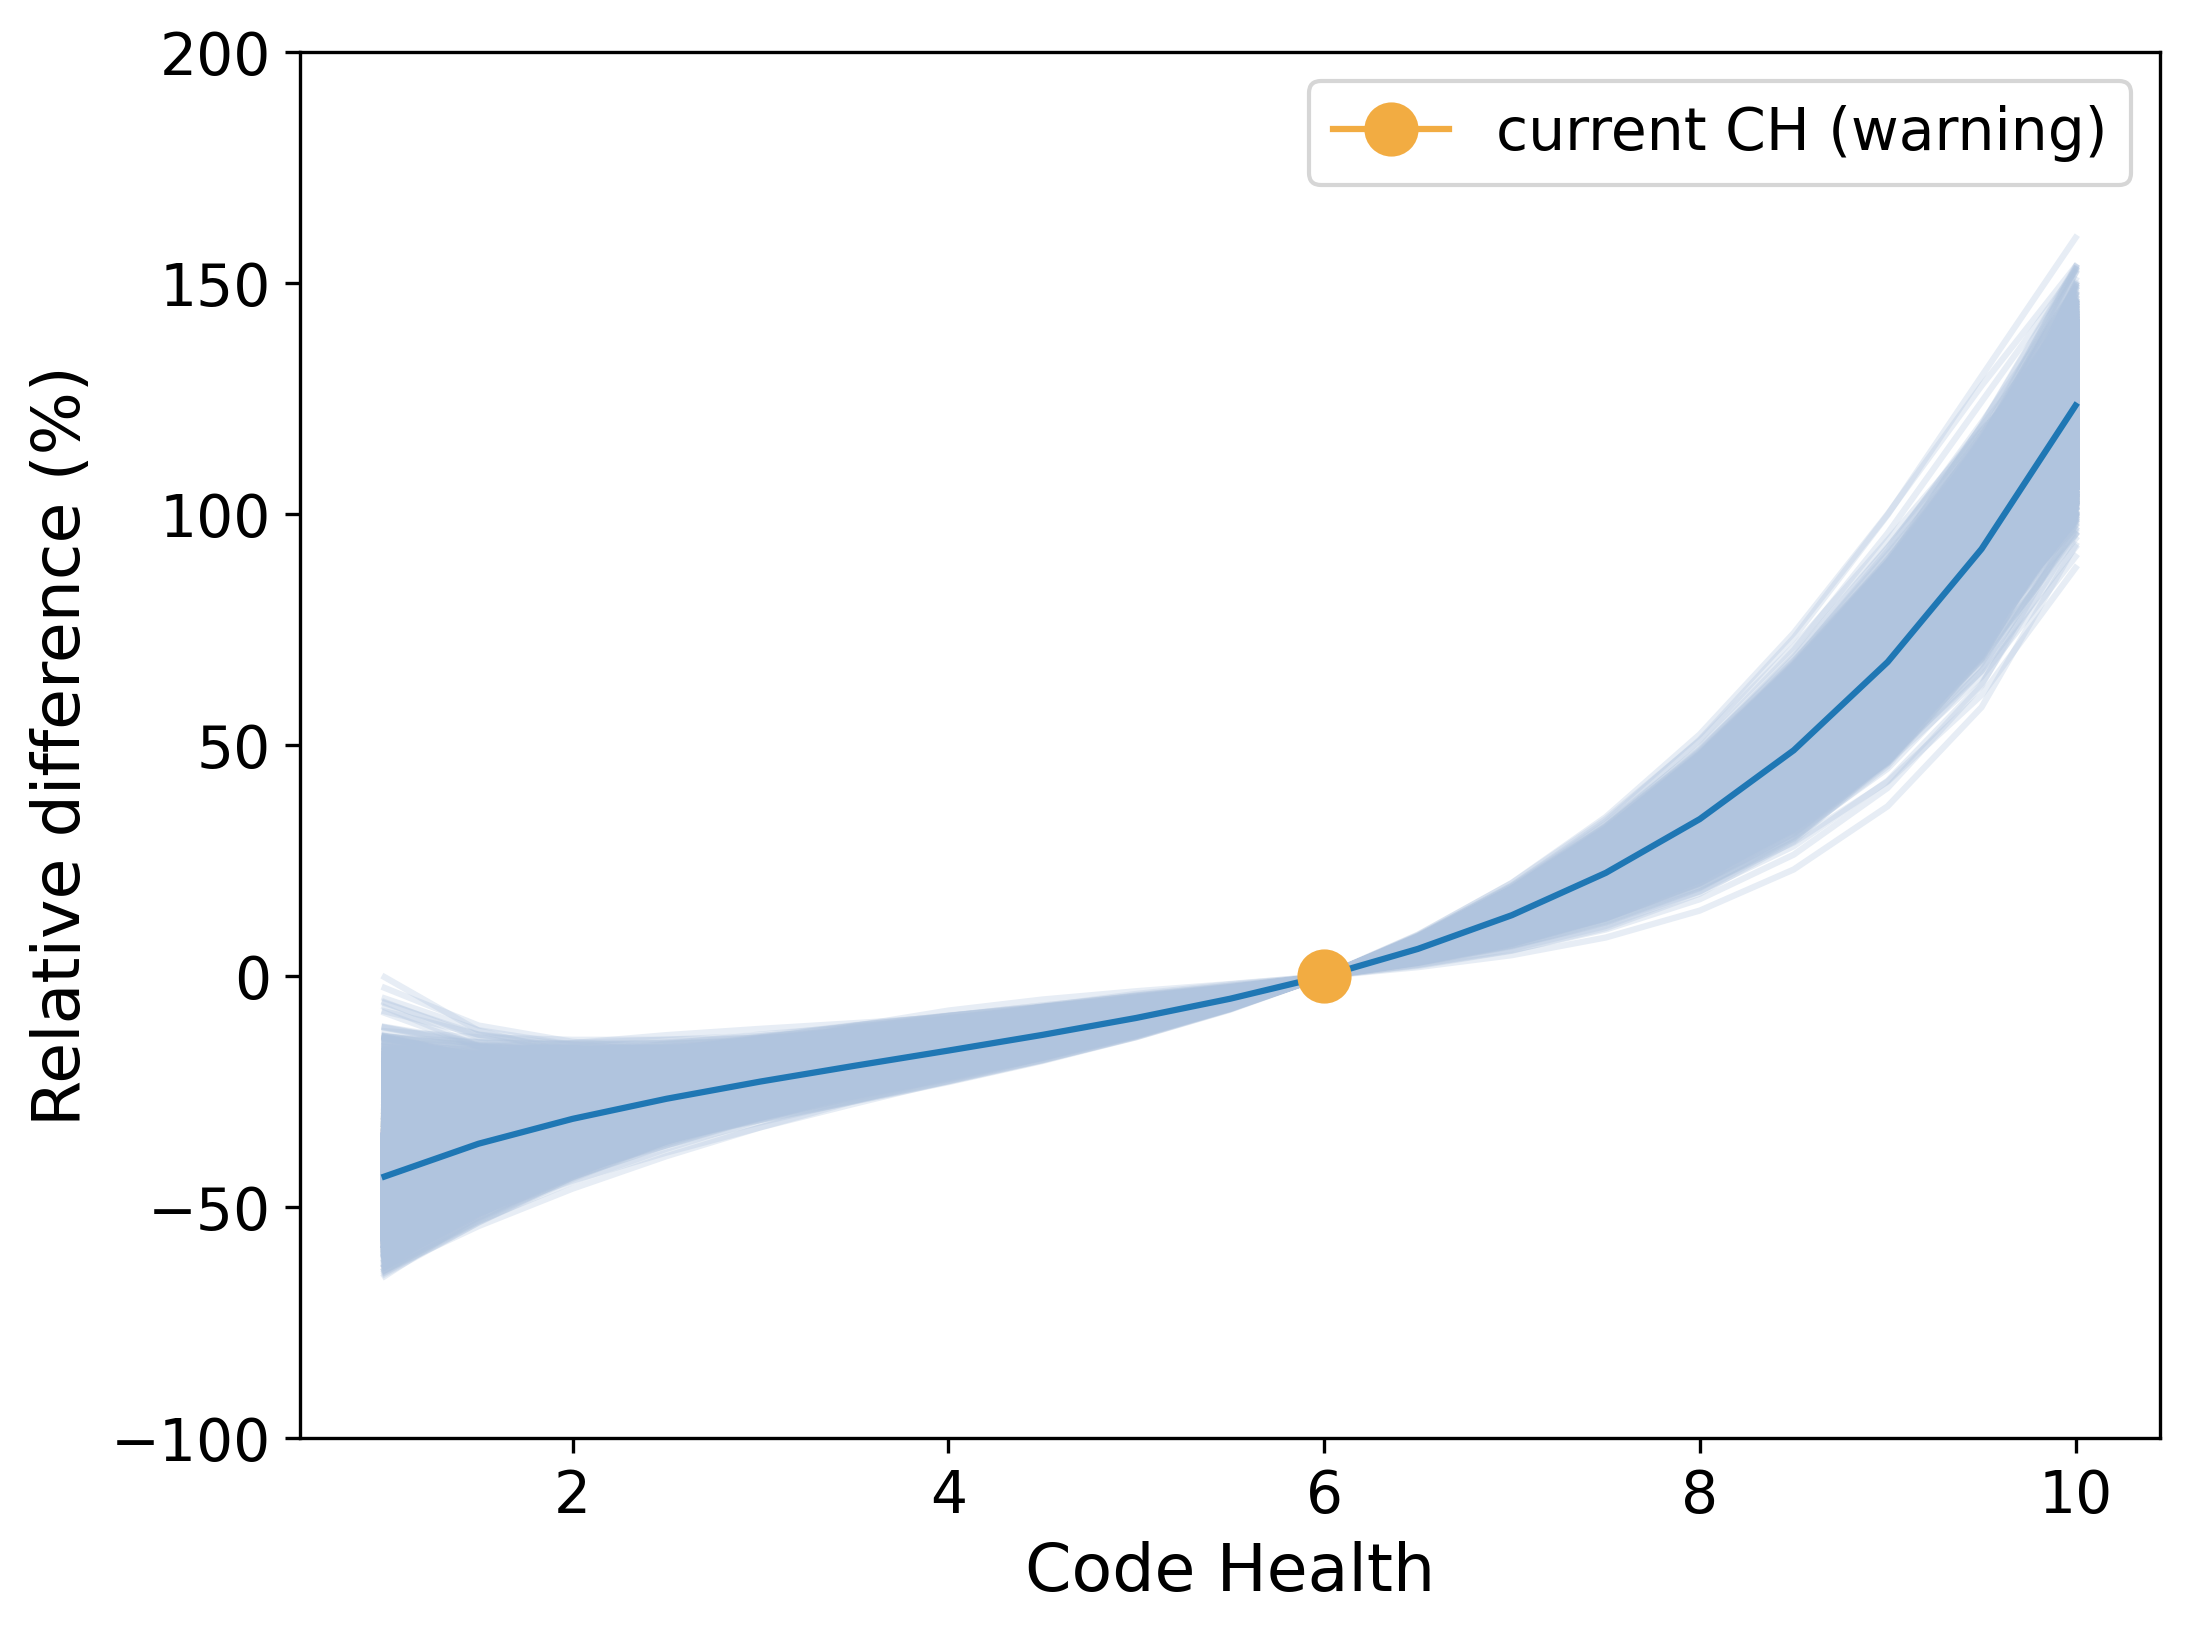

In [44]:
plot_value(100,6.0,0.12)

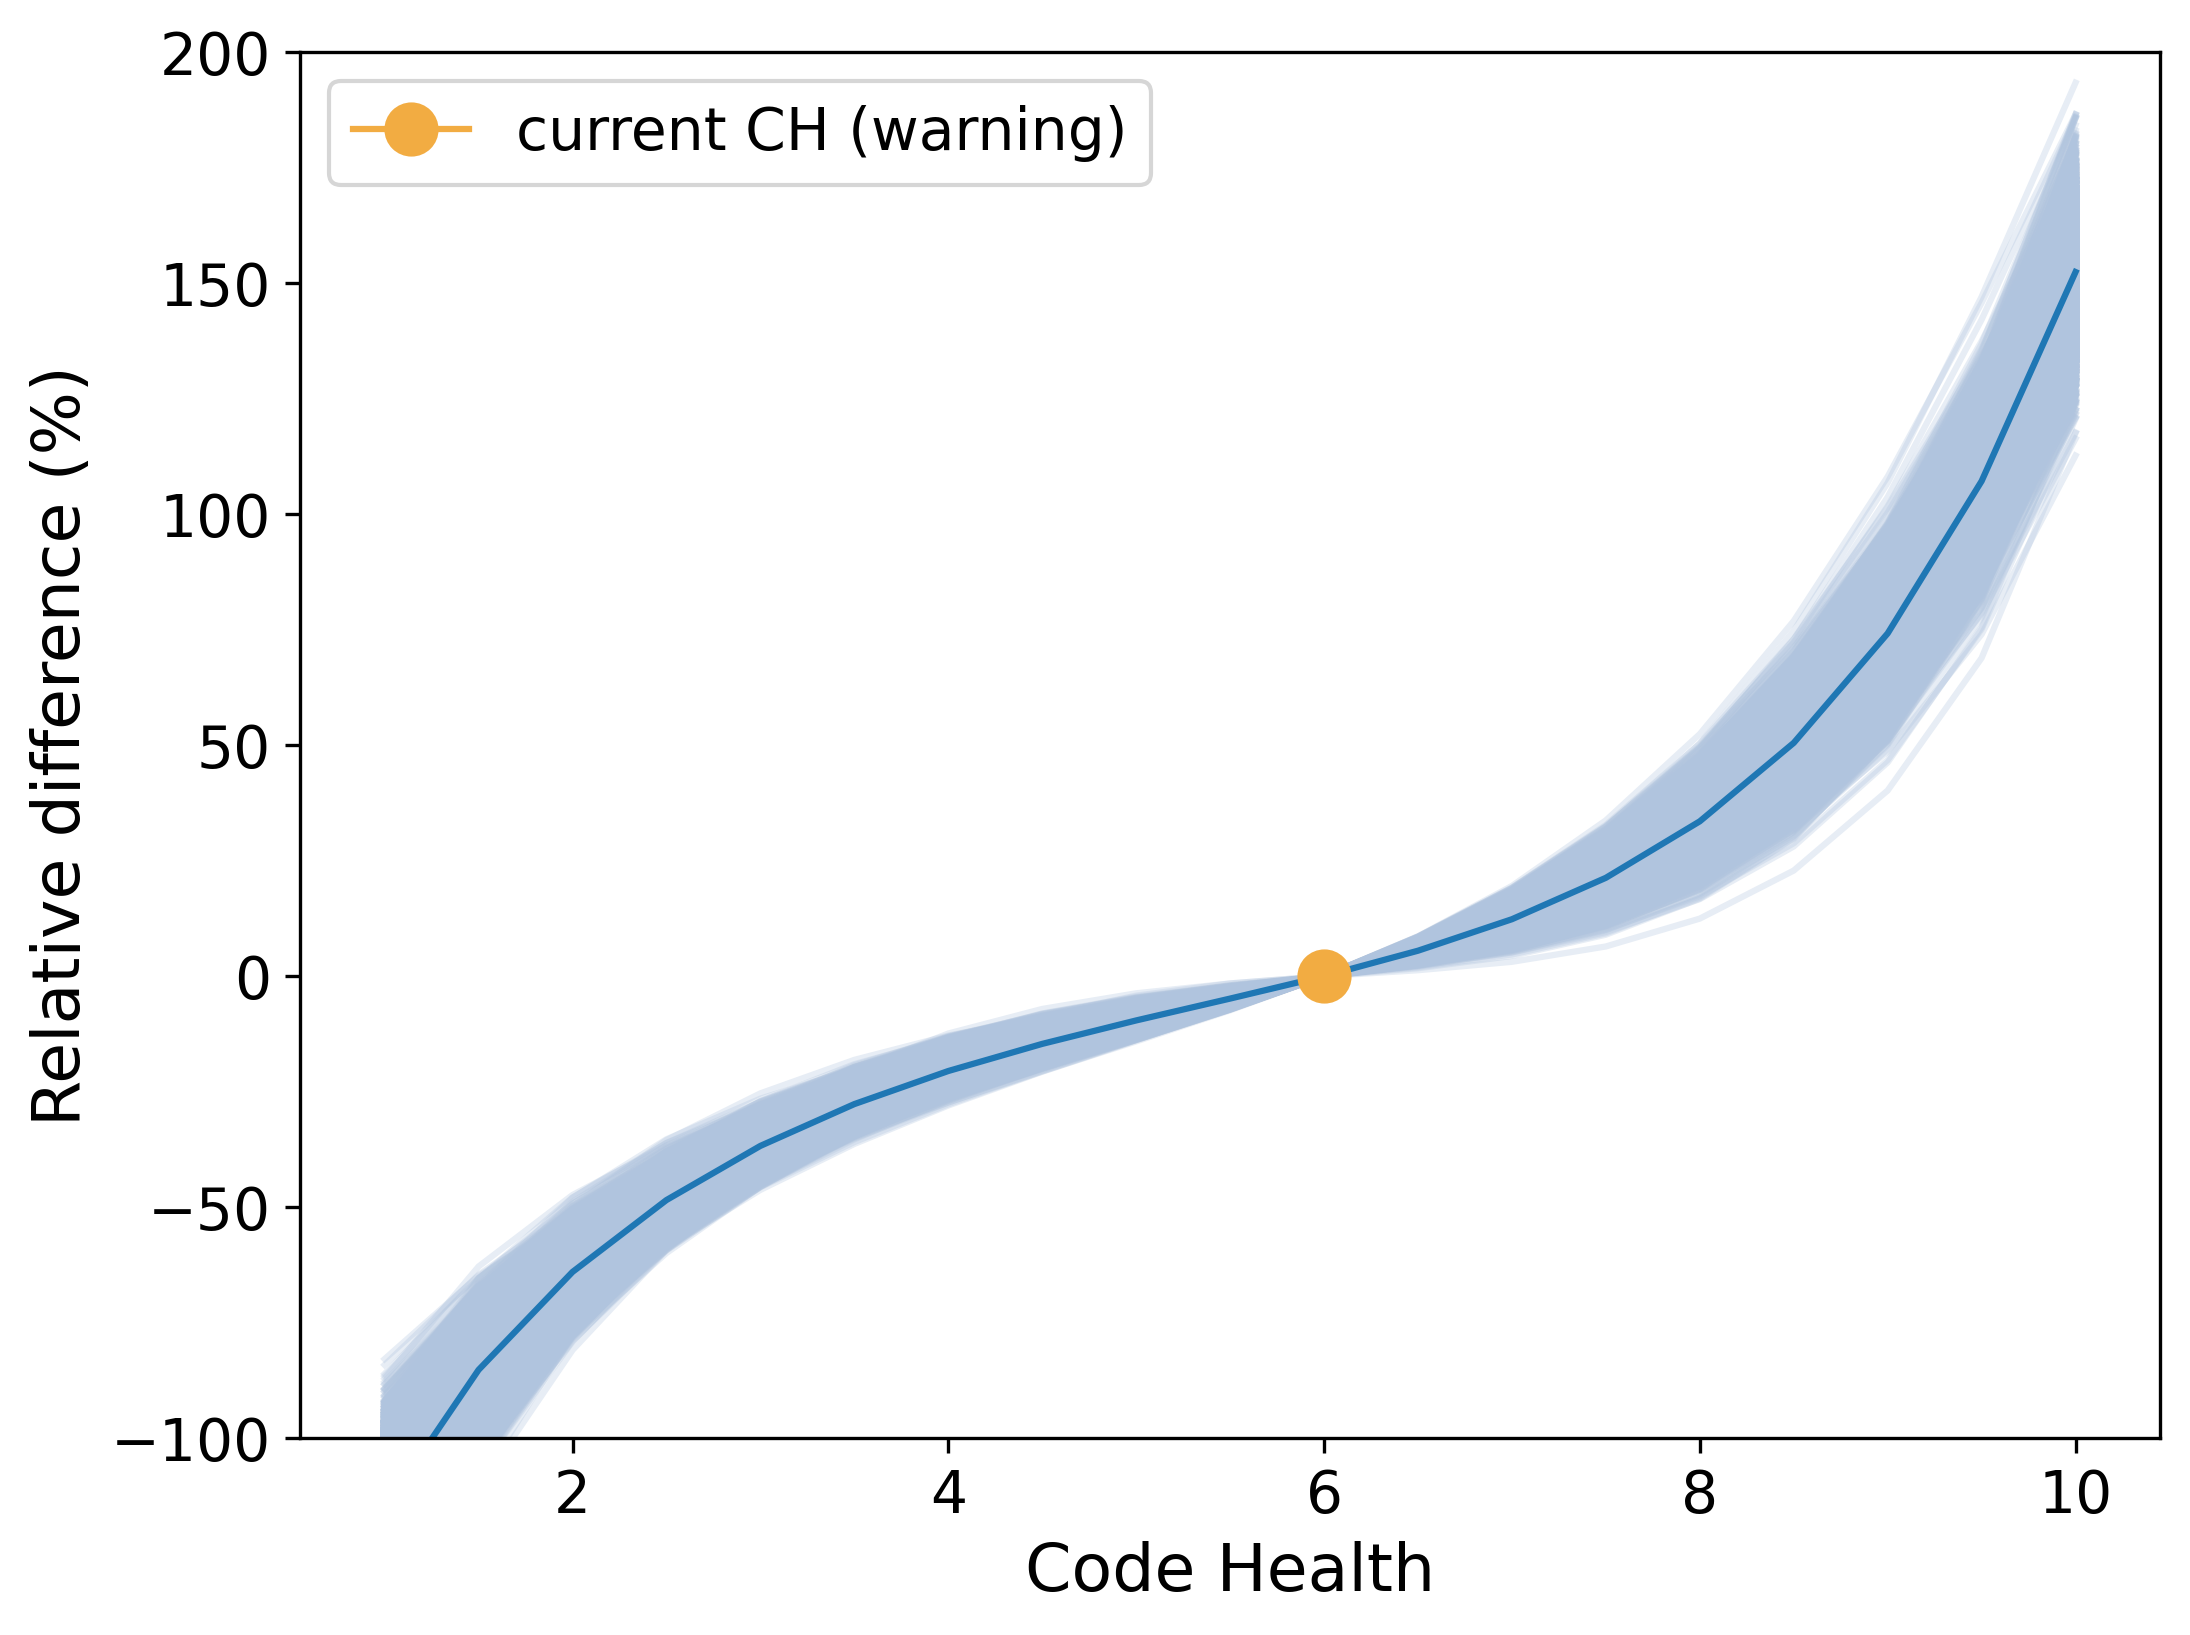

In [45]:
plot_value(100,6.0,0.25)

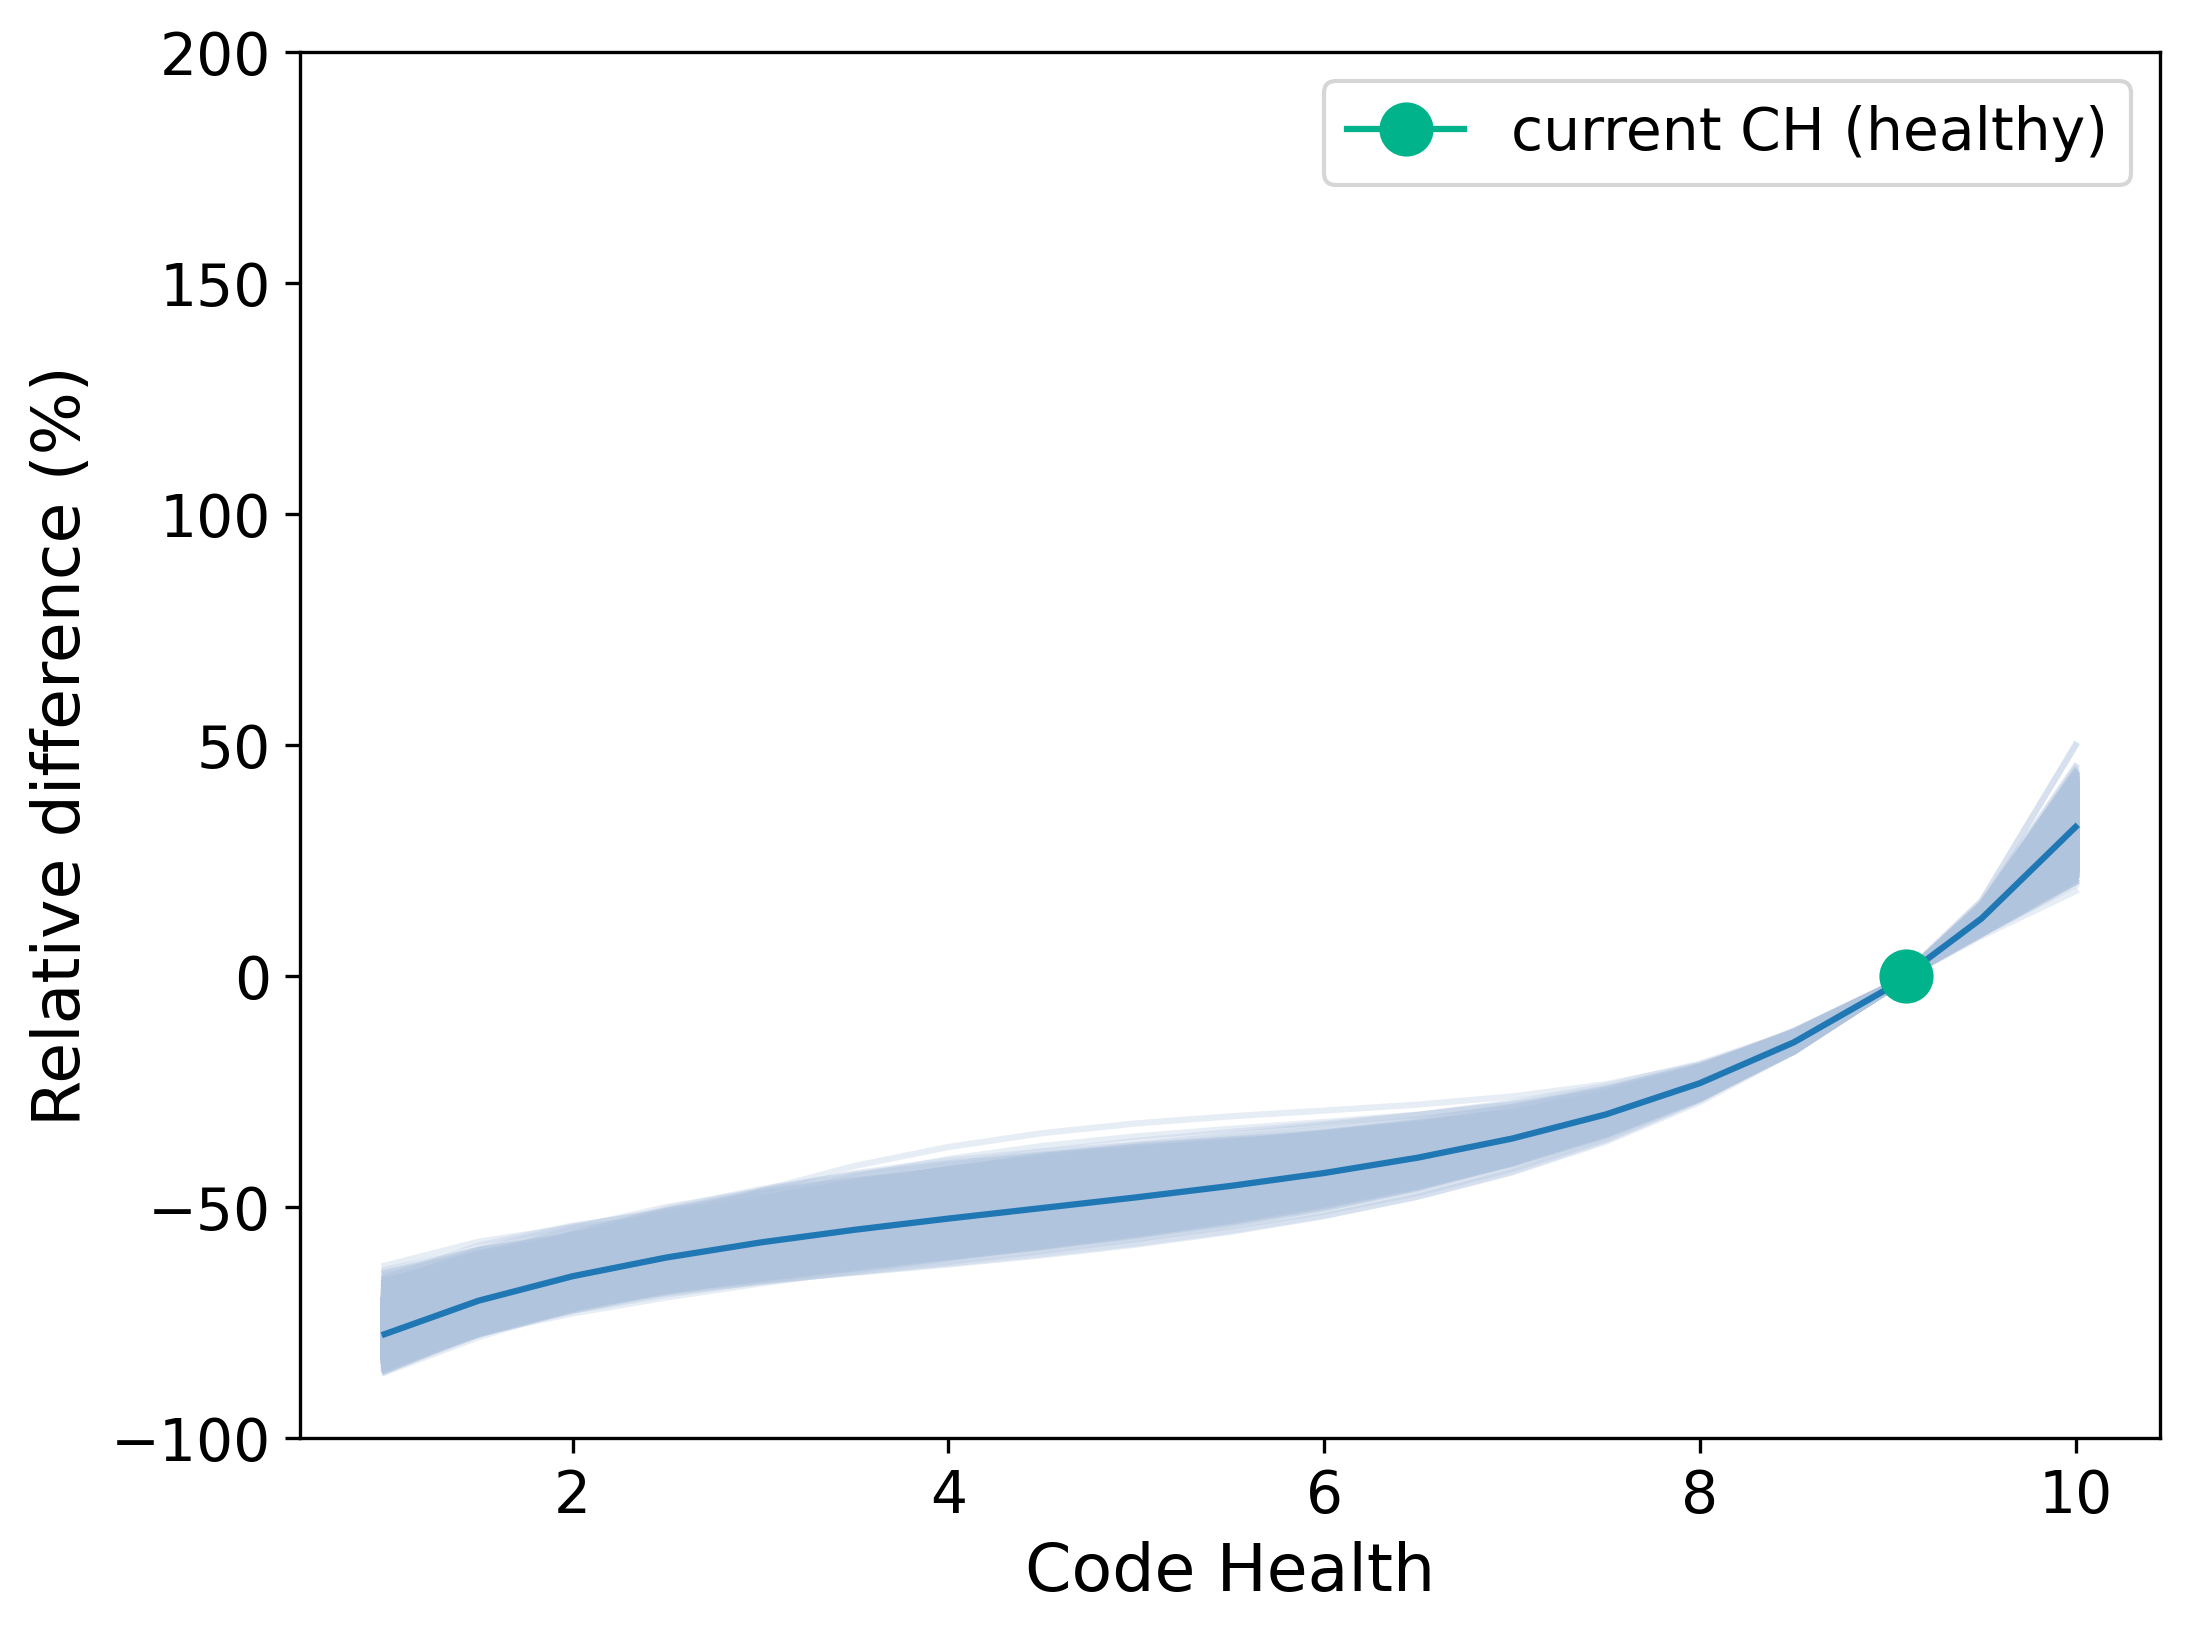

In [52]:
plot_value(100,9.1,0.12)

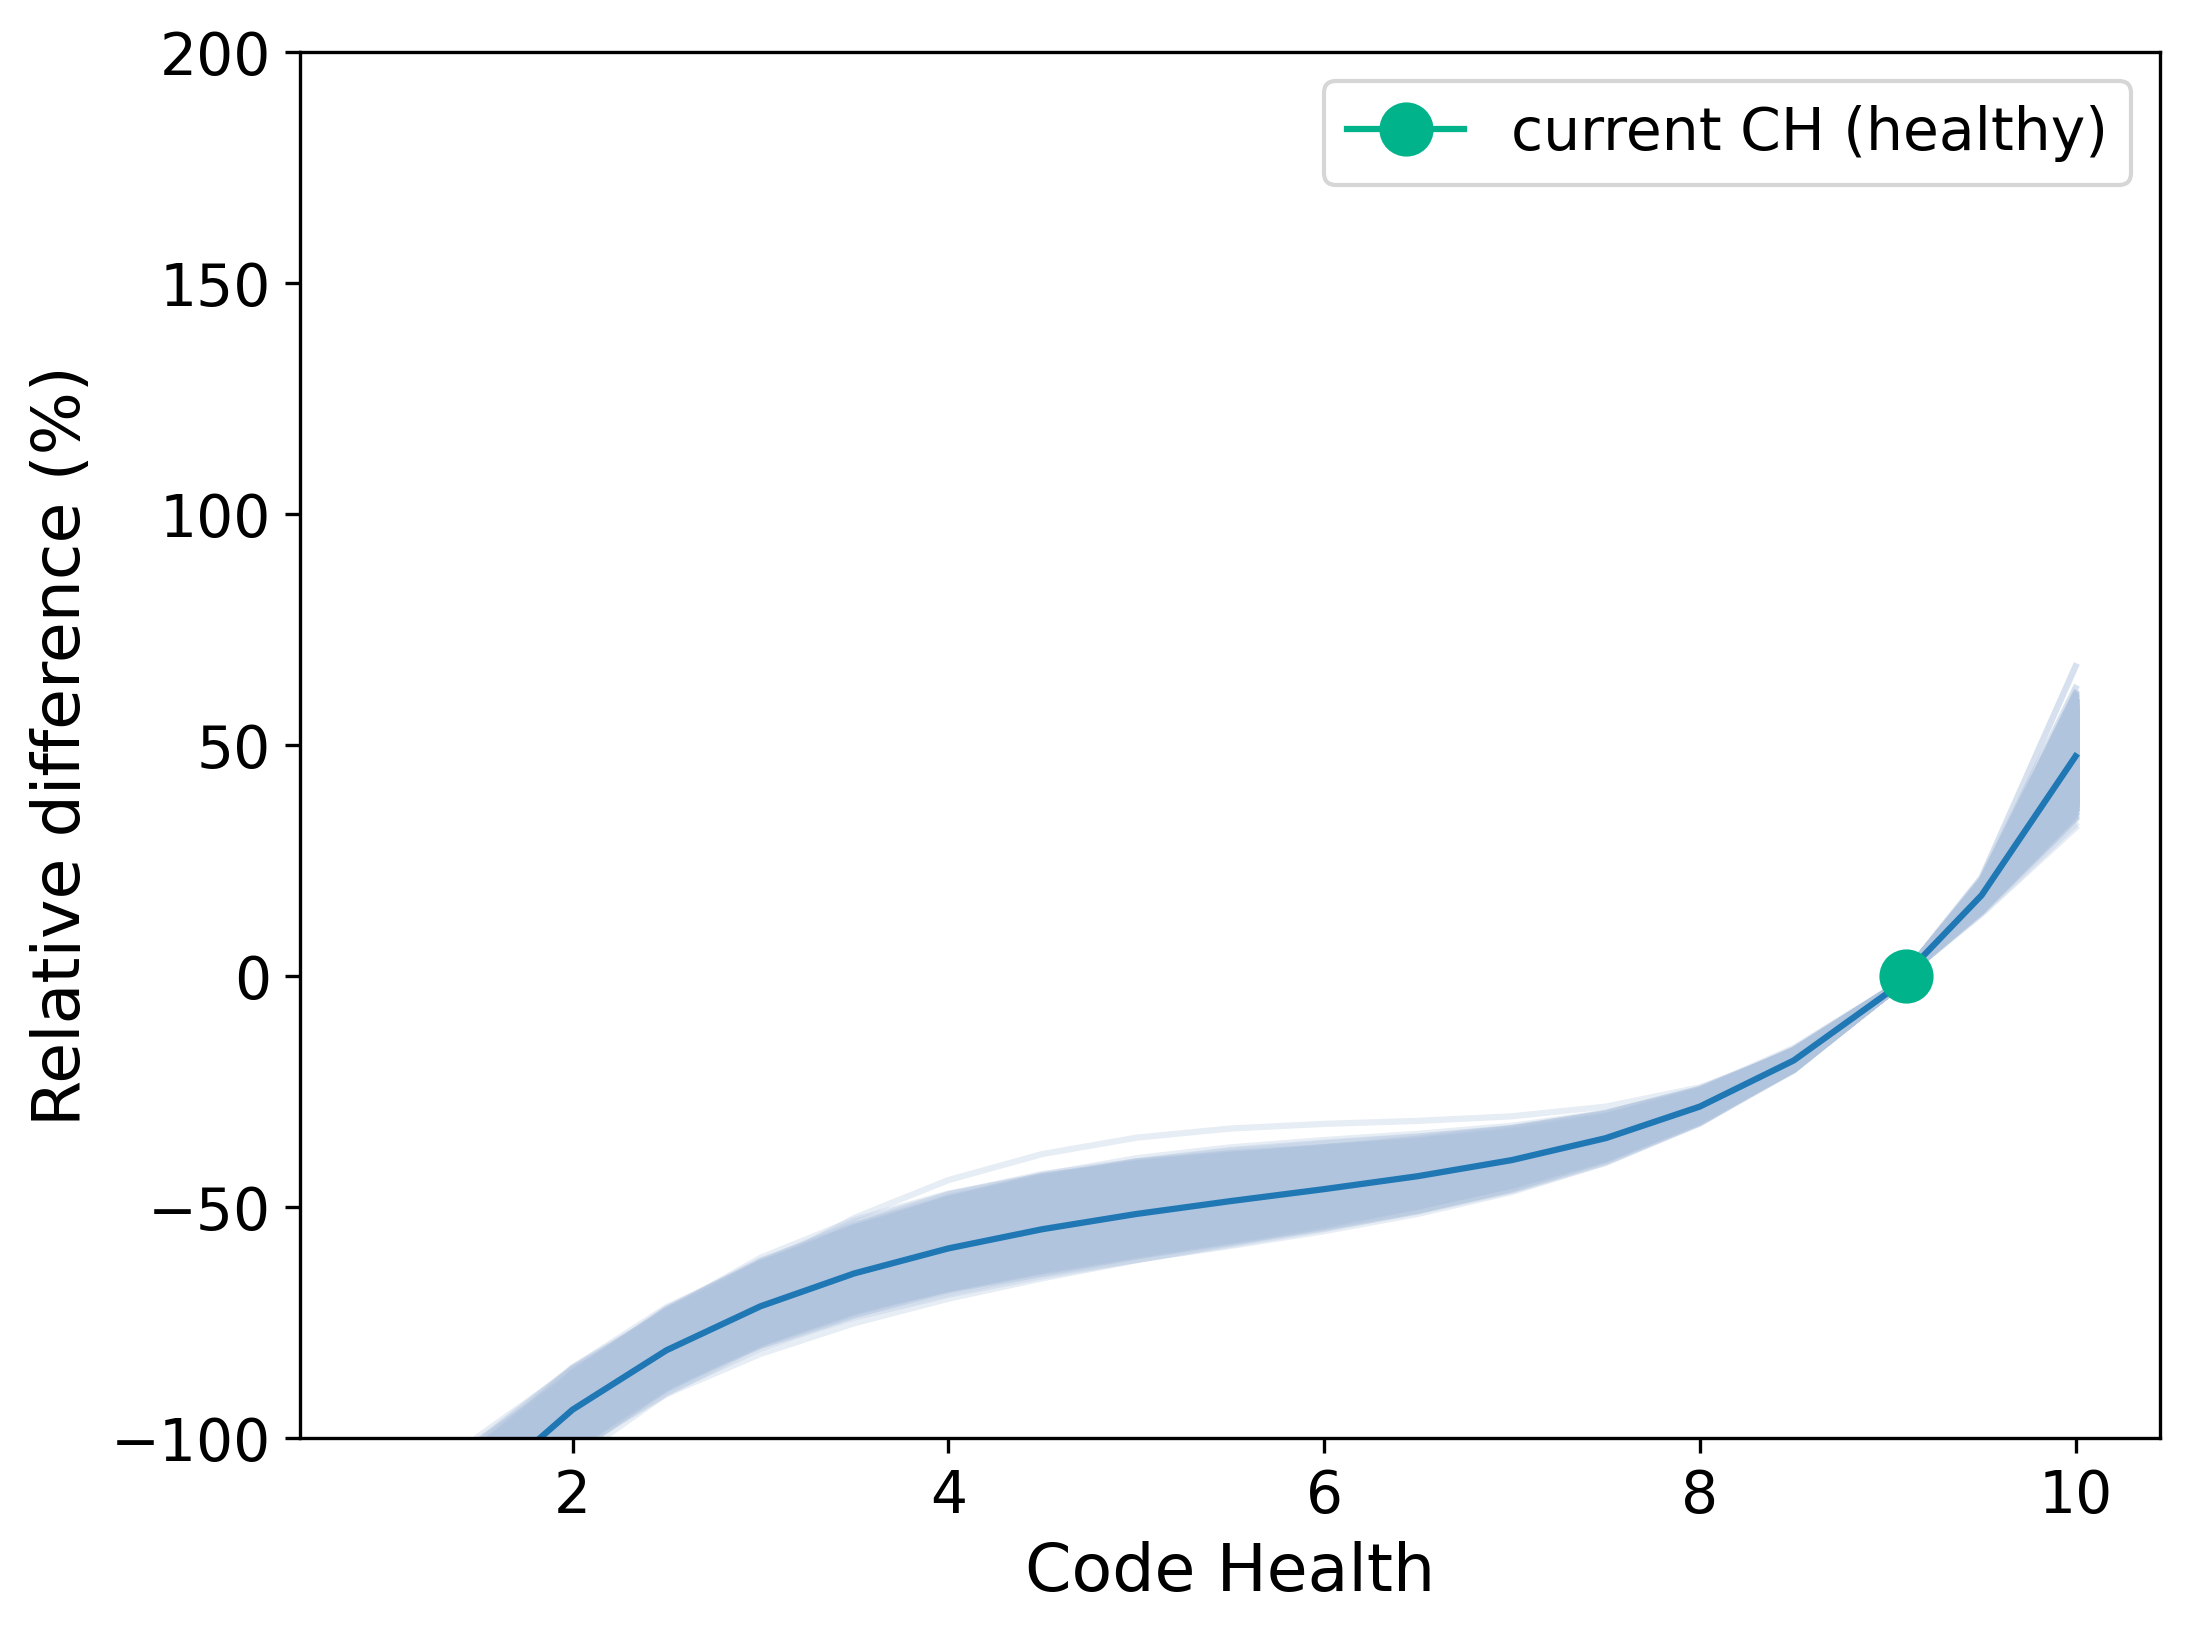

In [53]:
plot_value(100,9.1,0.25)